In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys
from collections import OrderedDict
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datasource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

0.4.1


float32 (500, 256, 256, 1) float32 (500, 256, 256)
float32 (1, 1, 256, 256) float32 (1, 1, 256, 256)


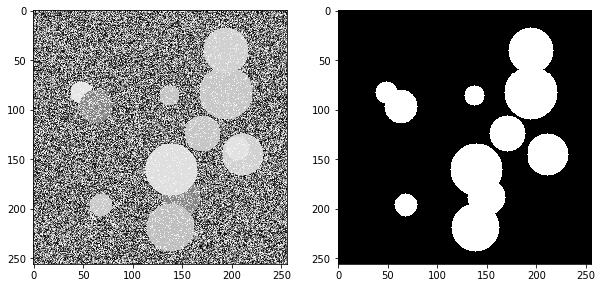

In [2]:
imwidth = 256
imheight = 256
numimgs = 500

dataset=[trainutils.createTestImage(imwidth,imheight,noiseMax=1.0) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

print(imgin.dtype,imgin.shape,maskin.dtype,maskin.shape)
src=datasource.DataSource(imgin,maskin,augments=[pytorchutils.convertAug])

with src.threadBatchGen(1) as gen:
    im,msk=gen()
    
print(im.dtype,im.shape,msk.dtype,msk.shape)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(im[0,0])
ax[1].imshow(msk[0,0])

In [3]:
class DAEMgrNB(pytorchutils.SegmentMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.SegmentMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        with self.src.threadBatchGen(self.batchSize) as gen:
            self.train(gen,self.trainSteps,1,10)
        
    def updateStep(self,step,steploss):
        self.updateGraphVals({'loss':steploss},('loss',))
        
        if step<10 or step%5==0:
            images,masks=self.traininputs
            logits,preds=self.netoutputs

            image=self.toNumpy(images[0,0])
            mask=self.toNumpy(masks[0,0])
            logit=self.toNumpy(logits[0,0])
            pred=self.toNumpy(preds[0])
            
            imgmap=OrderedDict([
                ('Image',image),
                ('Mask',mask),
                ('Logit',logit),
                ('Pred',pred),
                ('Diff',np.stack([mask,mask*pred,pred],axis=2).astype(np.float32)),
            ])
            
            self.updateImageVals(imgmap)
        

trainSteps=500
batchSize=20
channels= (4, 8, 16)
dilations=(1, 2,  4)
numKernels=2

net=pytorchnet.SegnetAE(1,1,[4],[2],interChannels=channels,interDilations=dilations,numInterUnits=numKernels)
    
mgr=DAEMgrNB(net,src,batchSize,trainSteps)
mgr.start()

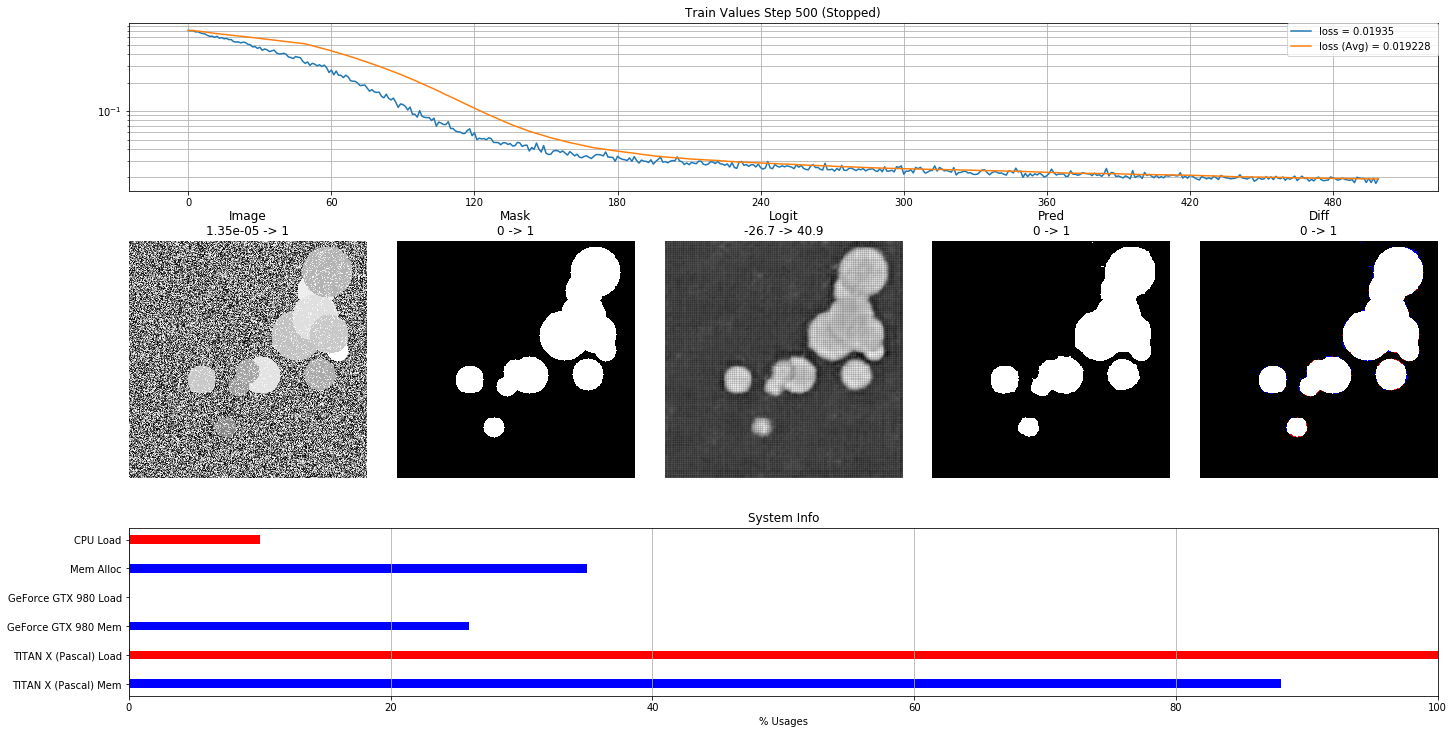

In [4]:
mgr.displayMonitor()